In [2]:
import pandas as pd


spike_df  = pd.read_csv("Final Spike Predictions.csv",  parse_dates=["time"])
tgpt_df   = pd.read_csv("Final TimesGPT Data.csv",      parse_dates=["time"])


df = (
    pd.merge(
        spike_df,
        tgpt_df,
        how="inner",      
        on="time",
        suffixes=("_spike", "_tgpt")  
    )
    .set_index("time")           
    .sort_index()                      
)

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2023-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pred_spike_prob  8760 non-null   float64
 1   pred_mag_MW      8760 non-null   float64
 2   true_spike       8760 non-null   int64  
 3   true_mag_MW      8760 non-null   float64
 4   Unnamed: 0       8760 non-null   int64  
 5   unique_id        8760 non-null   int64  
 6   DAP              8760 non-null   float64
 7   TimeGPT          8760 non-null   float64
 8   TimeGPT-hi-90    8760 non-null   float64
 9   TimeGPT-lo-90    8760 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 752.8 KB
None
                     pred_spike_prob  pred_mag_MW  true_spike  true_mag_MW  \
time                                                                         
2023-01-01 00:00:00         0.000269    11.166585           0          0.0   
2023-01-01 01:

In [3]:
df = df.drop(['true_spike', 'true_mag_MW', 'Unnamed: 0', 'unique_id', 'TimeGPT-hi-90', 'TimeGPT-lo-90'], axis = 1)

In [4]:
df

,pred_spike_prob,pred_mag_MW,DAP,TimeGPT
time,,,,
2023-01-01 00:00:00,0.000269,11.166585,10.83340,0.794704
2023-01-01 01:00:00,0.000272,12.847394,10.22220,2.510757
2023-01-01 02:00:00,0.000188,12.488766,8.73719,-0.742447
2023-01-01 03:00:00,0.000166,11.972310,8.19749,2.853043
2023-01-01 04:00:00,0.000165,11.738667,8.33215,9.884354
...,...,...,...,...
2023-12-31 19:00:00,0.001989,9.345063,19.37150,16.540146
2023-12-31 20:00:00,0.001092,9.124728,16.77390,13.965488
2023-12-31 21:00:00,0.000679,9.029976,15.00350,12.675762


In [5]:
import numpy as np

SPIKE_THRESHOLD = 0.0          # e.g. set to 0.7, 0.5, etc.

df["final_pred"] = np.where(
    df["pred_spike_prob"] > SPIKE_THRESHOLD,
    (1 - df["pred_spike_prob"]) * df["TimeGPT"]
    + df["pred_spike_prob"]   * df["pred_mag_MW"],
    df["TimeGPT"]
)

df


,pred_spike_prob,pred_mag_MW,DAP,TimeGPT,final_pred
time,,,,,
2023-01-01 00:00:00,0.000269,11.166585,10.83340,0.794704,0.797496
2023-01-01 01:00:00,0.000272,12.847394,10.22220,2.510757,2.513569
2023-01-01 02:00:00,0.000188,12.488766,8.73719,-0.742447,-0.739957
2023-01-01 03:00:00,0.000166,11.972310,8.19749,2.853043,2.854557
2023-01-01 04:00:00,0.000165,11.738667,8.33215,9.884354,9.884660
...,...,...,...,...,...
2023-12-31 19:00:00,0.001989,9.345063,19.37150,16.540146,16.525833
2023-12-31 20:00:00,0.001092,9.124728,16.77390,13.965488,13.960204
2023-12-31 21:00:00,0.000679,9.029976,15.00350,12.675762,12.673286


In [6]:
import numpy as np
from sklearn.metrics import mean_absolute_error 

mae = mean_absolute_error(df["DAP"], df["final_pred"])
print(f"MAE for {df.index.year.unique().tolist()} : {mae:,.3f} $/MWh")


MAE for [2023] : 20.582 $/MWh


In [7]:
from sklearn.metrics import mean_absolute_error

AUG_YEAR = 2023   

aug_mask = df.index.month == 8
if AUG_YEAR is not None:
    aug_mask &= df.index.year == AUG_YEAR

aug_df = df.loc[aug_mask]

# Guard-rail: check that we actually captured data
if aug_df.empty:
    raise ValueError(f"No August data found for year = {AUG_YEAR}")

# Compute MAE
mae_august = mean_absolute_error(aug_df["DAP"], aug_df["final_pred"])

print(f"MAE for August{'' if AUG_YEAR is None else ' ' + str(AUG_YEAR)}: {mae_august:,.3f} $/MWh")


MAE for August 2023: 95.107 $/MWh


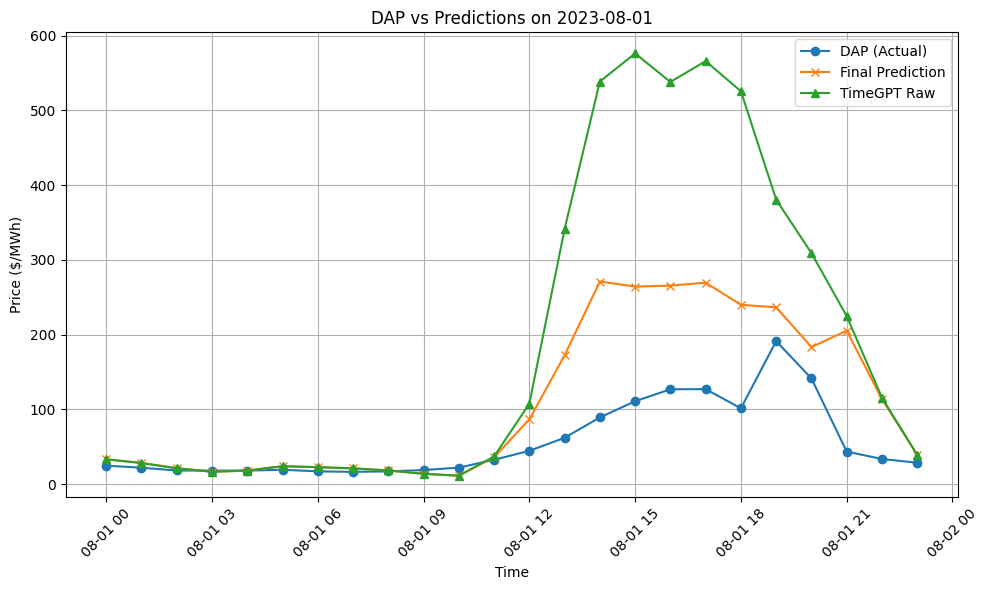

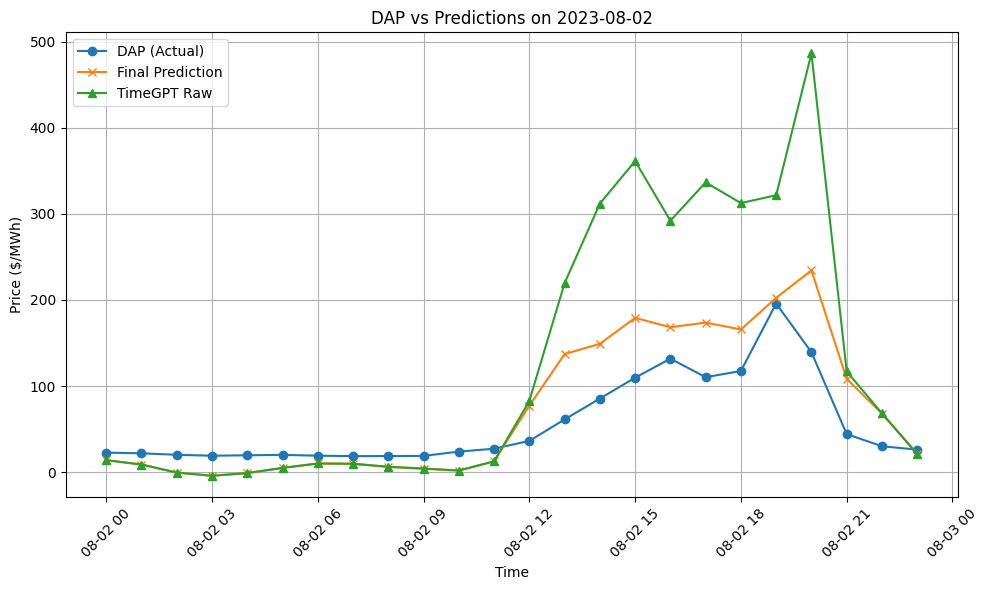

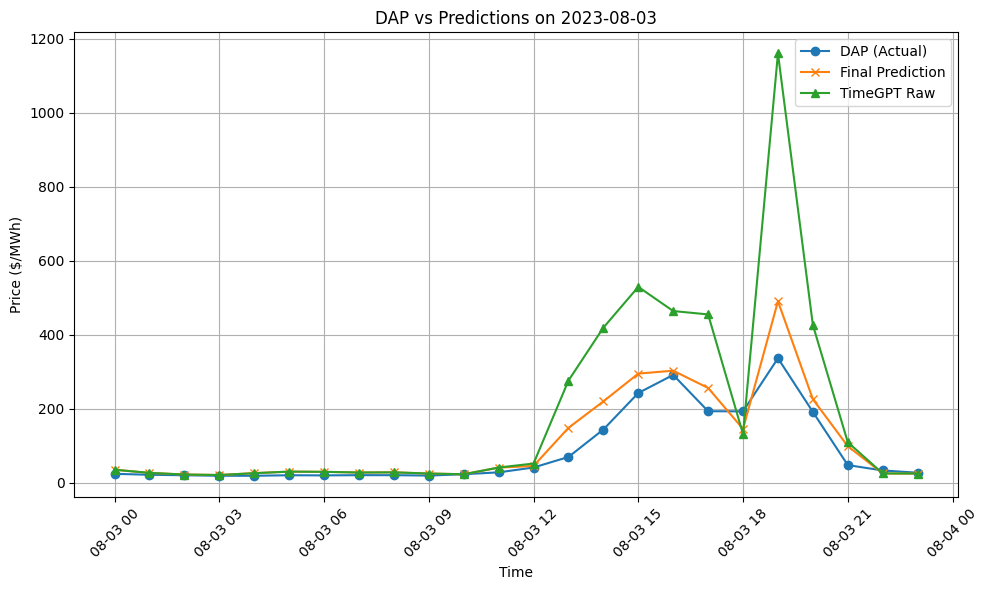

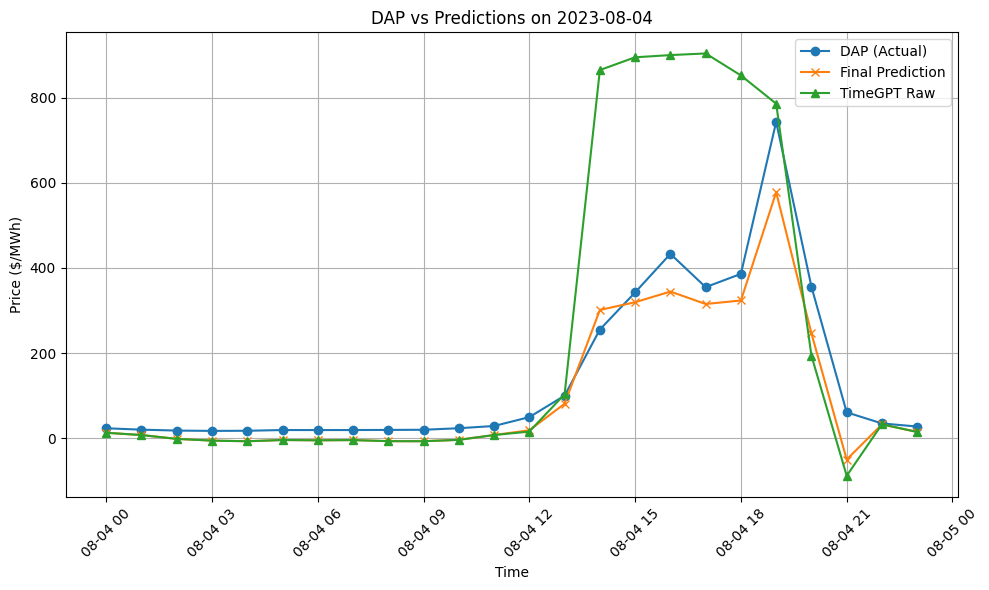

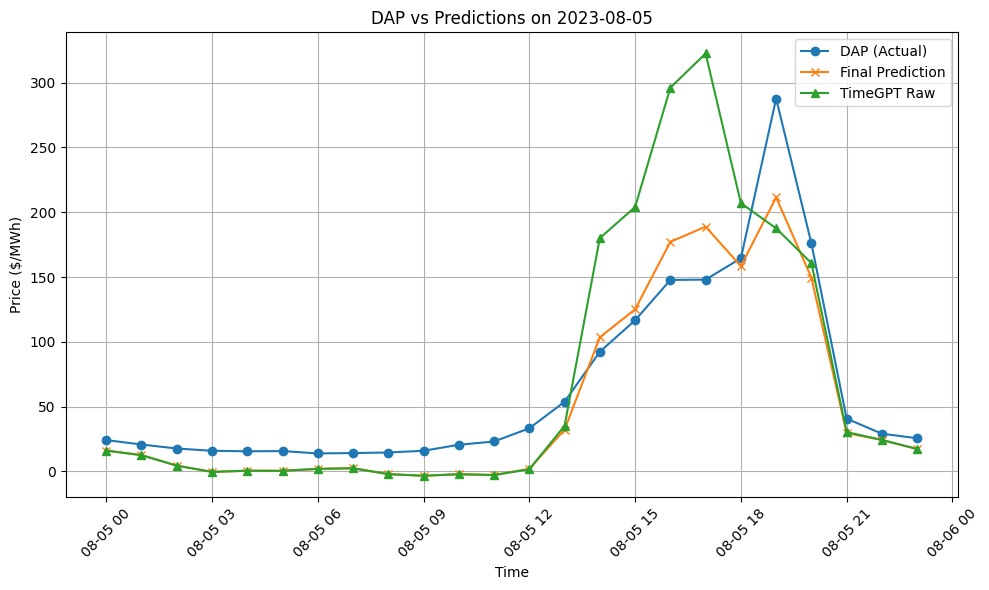

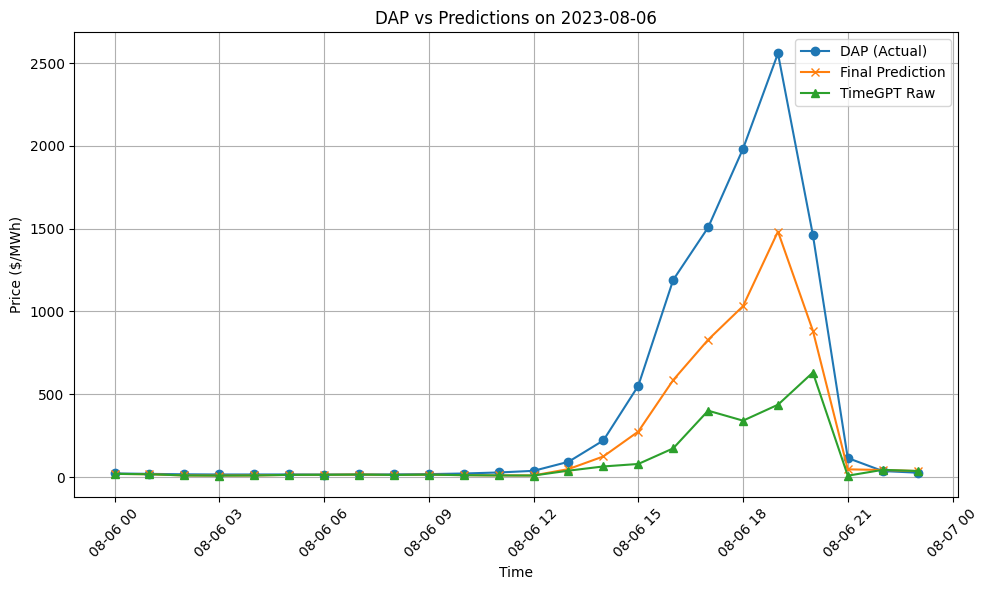

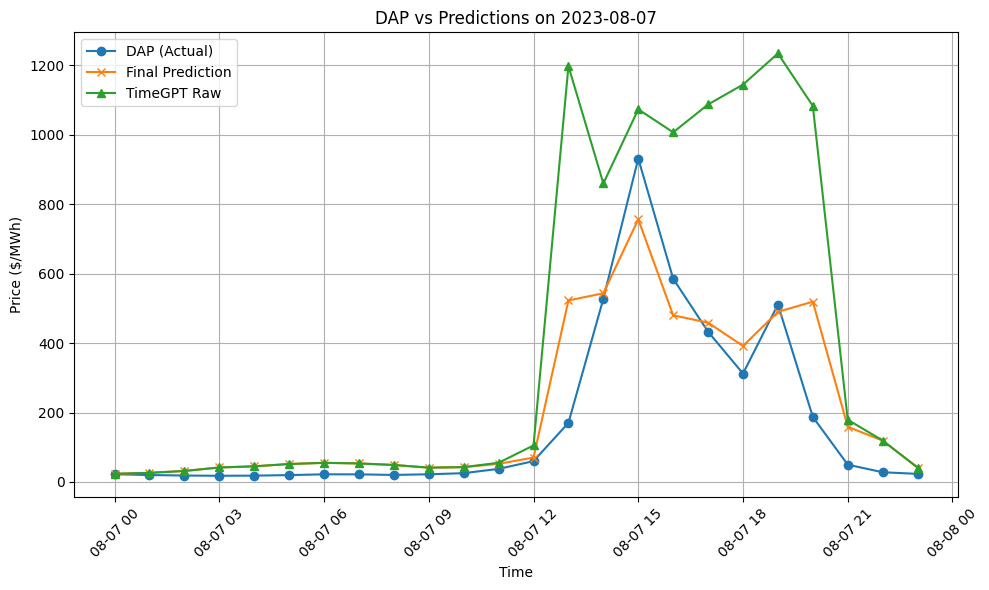

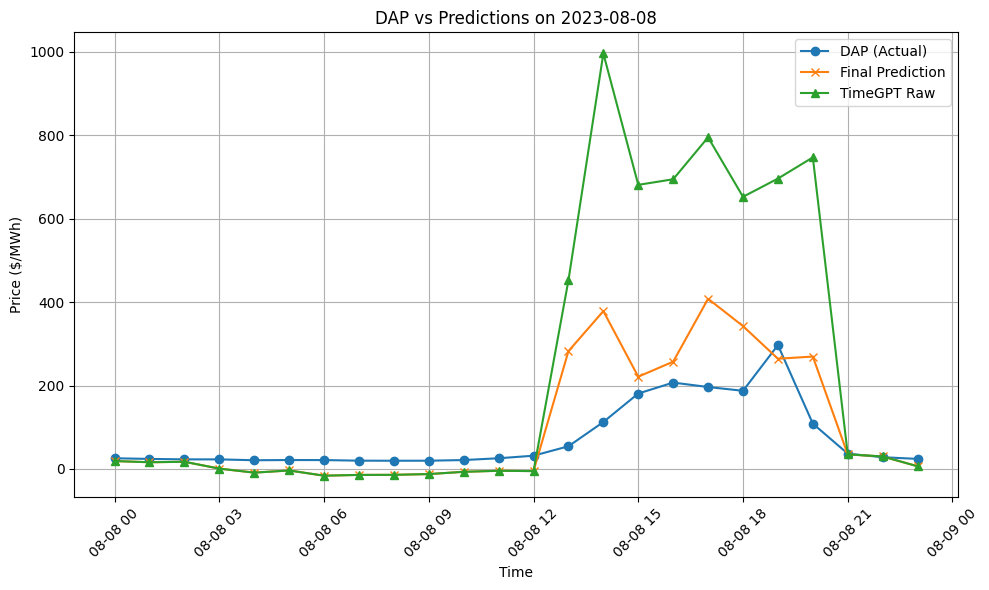

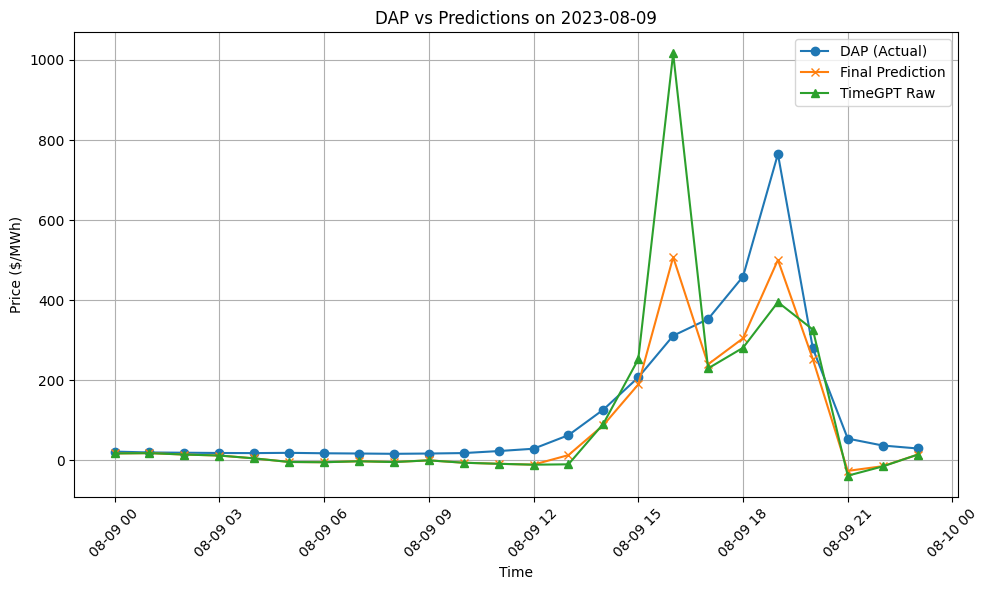

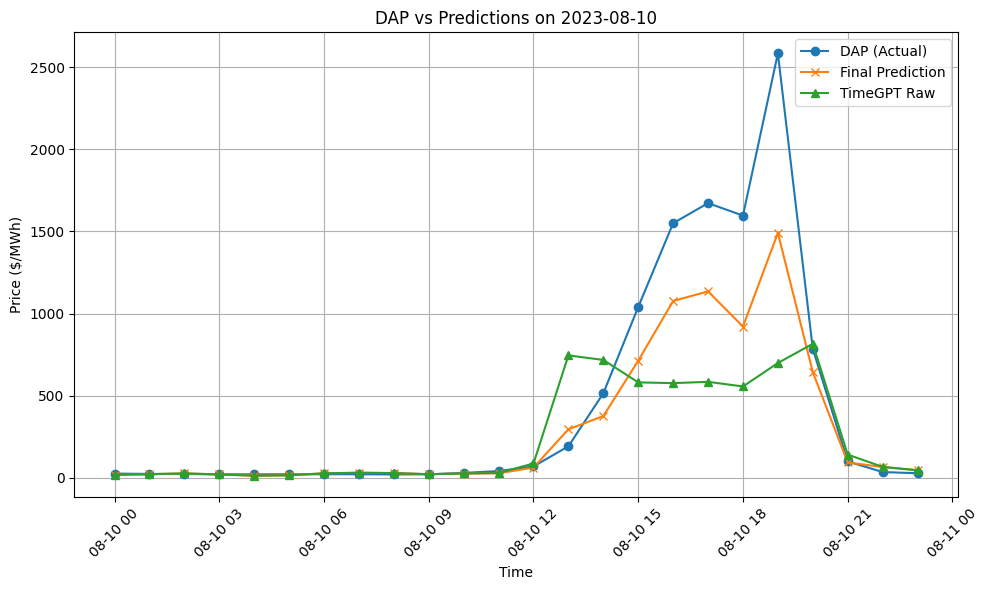

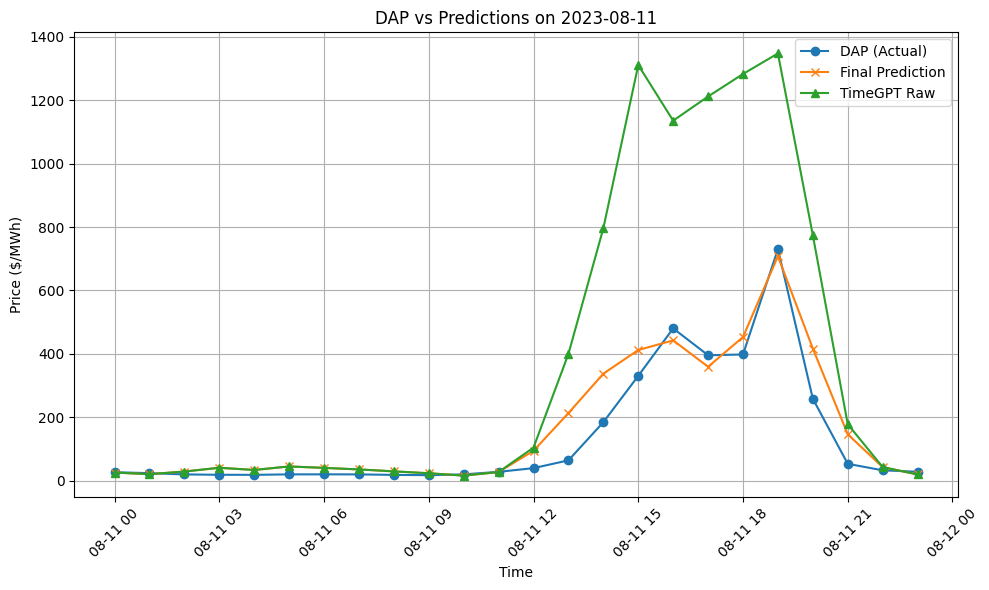

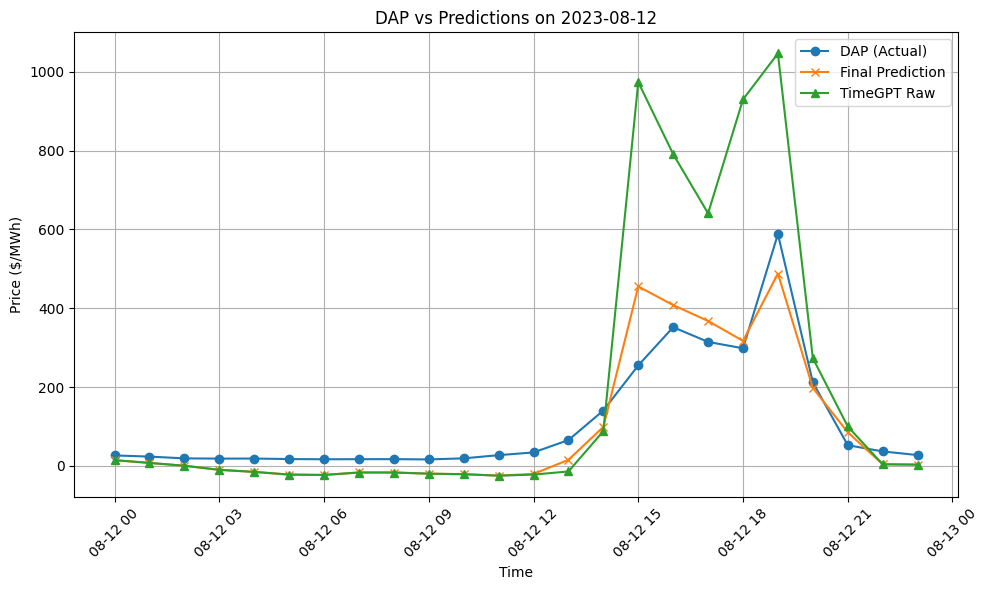

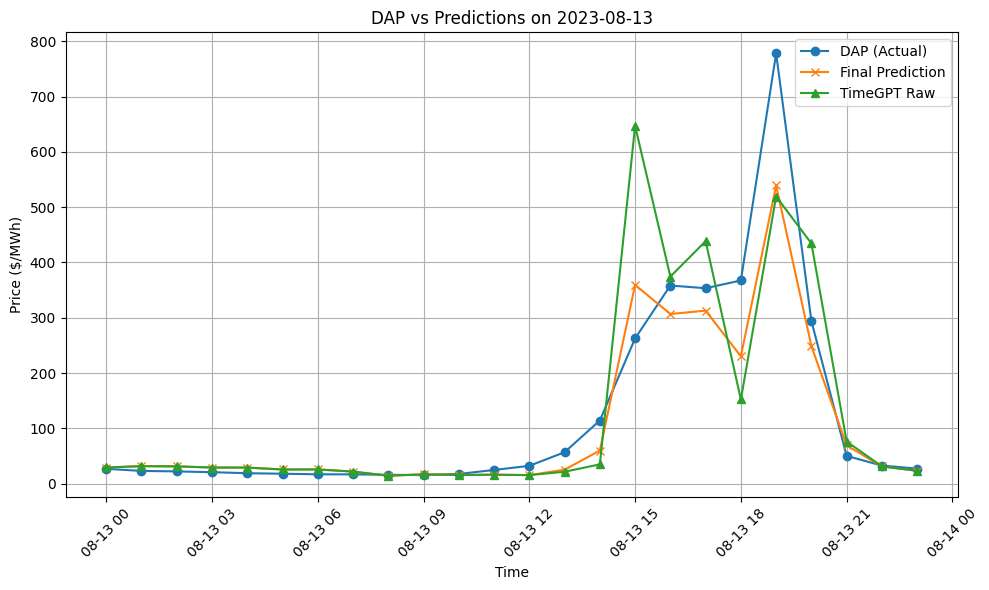

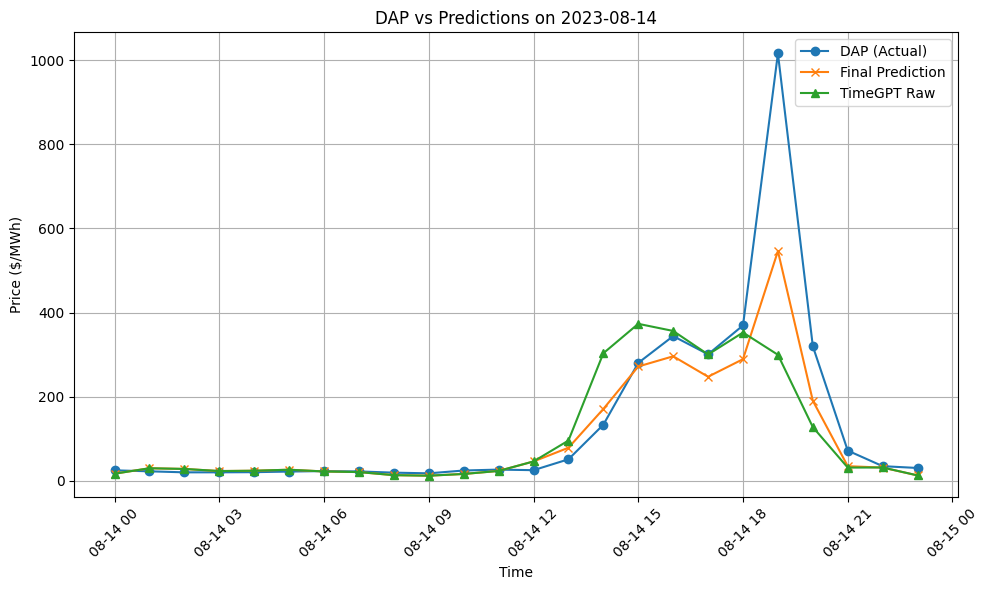

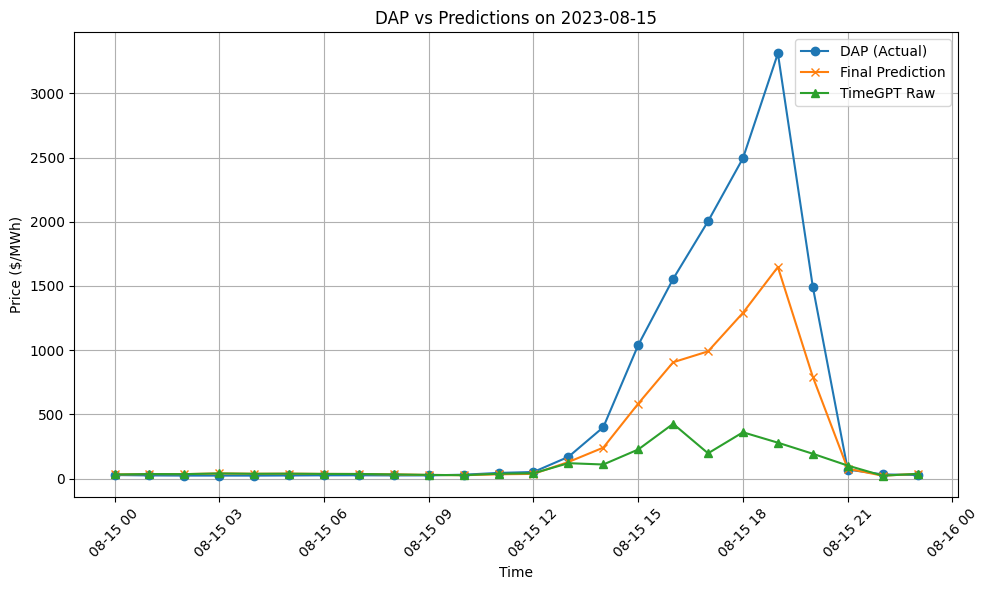

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Define date range
start_date = "2023-08-01"
end_date   = "2023-08-15"

# Generate daily plots
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

for day in date_range:
    day_str = day.strftime('%Y-%m-%d')
    day_df = df.loc[day_str]

    plt.figure(figsize=(10, 6))
    plt.plot(day_df.index, day_df['DAP'], label='DAP (Actual)', marker='o')
    plt.plot(day_df.index, day_df['final_pred'], label='Final Prediction', marker='x')
    plt.plot(day_df.index, day_df['TimeGPT'], label='TimeGPT Raw', marker='^')
    plt.title(f'DAP vs Predictions on {day_str}')
    plt.xlabel('Time')
    plt.ylabel('Price ($/MWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
df.loc["2023-08-03"].between_time("12:00", "21:00")

,pred_spike_prob,pred_mag_MW,DAP,TimeGPT,final_pred
time,,,,,
2023-08-03 12:00:00,0.195118,19.013319,41.39130,52.084602,45.631807
2023-08-03 13:00:00,0.549036,43.573790,69.86160,276.208280,148.483547
2023-08-03 14:00:00,0.646141,110.862015,143.96100,419.112550,219.939241
2023-08-03 15:00:00,0.683414,186.538560,242.63499,529.358340,295.070571
2023-08-03 16:00:00,0.670287,223.668850,291.46399,464.014340,302.913955
2023-08-03 17:00:00,0.659367,153.598970,193.38200,454.891170,256.228976
2023-08-03 18:00:00,0.678663,152.129260,193.05901,131.686970,145.560393
2023-08-03 19:00:00,0.735991,250.259770,336.49899,1159.841900,490.397730
2023-08-03 20:00:00,0.730757,152.064150,191.56300,426.388460,225.924050
